### Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import nltk.classify.util
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.classify import NaiveBayesClassifier
import numpy as np
import re
import string
import nltk
%matplotlib inline

#Show 30 columns
pd.set_option('max_columns', 30)
pd.get_option("display.max_columns")

30

In [2]:
# Read Data
temp = pd.read_csv('1429_1.csv')
temp.head()
for cols in temp.columns:
    print(cols)

id
name
asins
brand
categories
keys
manufacturer
reviews.date
reviews.dateAdded
reviews.dateSeen
reviews.didPurchase
reviews.doRecommend
reviews.id
reviews.numHelpful
reviews.rating
reviews.sourceURLs
reviews.text
reviews.title
reviews.userCity
reviews.userProvince
reviews.username


/home/adolf/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (1,10) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


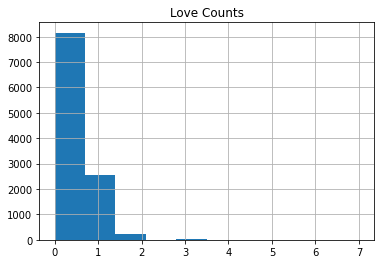

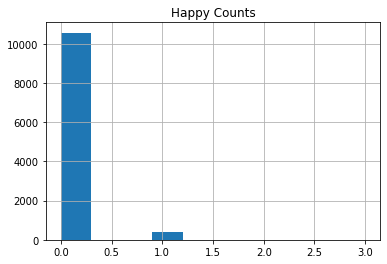

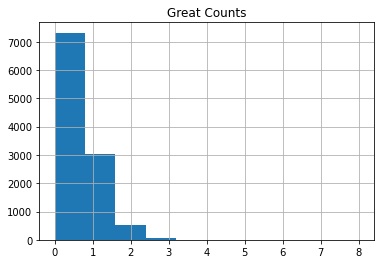

In [3]:
# Fire tab data filters to Amazon Fire Tab records
fire_tab = temp[temp.asins=='B018Y229OU'].copy(deep = True)
reviews_len = fire_tab['reviews.text'].str.len()
love_count = fire_tab['reviews.text'].str.lower().str.count('love')
love_count.hist()
plt.title('Love Counts')
plt.show()
happy_count = fire_tab['reviews.text'].str.lower().str.count('happy')
happy_count.hist()
plt.title('Happy Counts')
plt.show()
great_count = fire_tab['reviews.text'].str.lower().str.count('great')
great_count.hist()
plt.title('Great Counts')
plt.show()

<AxesSubplot:>

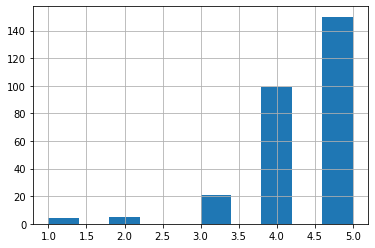

In [4]:
# Most reviews for fire tab say that the camera is good
fire_tab[fire_tab['reviews.text'].str.lower().str.contains('camera')]['reviews.rating'].hist()

In [5]:
print(reviews_len.sort_values().head(10))
print(reviews_len.sort_values().tail(10))

6724      6
10333    48
14478    48
13337    49
10742    49
8282     49
11298    49
7770     49
11267    50
4313     50
Name: reviews.text, dtype: int64
11959    1844
4353     1976
6019     2008
13633    2011
9395     2043
11631    2105
5680     2216
6027     2671
9547     2678
12021    3097
Name: reviews.text, dtype: int64


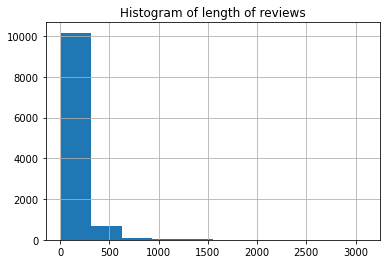

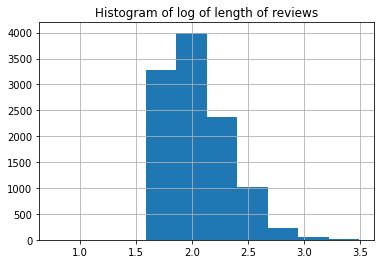

In [6]:
reviews_len.hist()
plt.title('Histogram of length of reviews')
plt.show()
np.log10(reviews_len).hist()
plt.title('Histogram of log of length of reviews')
plt.show()

In [7]:
permanent = fire_tab[['reviews.rating' , 'reviews.text' , 'reviews.title' , 'reviews.username']]
print(permanent.isnull().sum()) #Checking for null values
permanent.head()

reviews.rating      0
reviews.text        0
reviews.title       0
reviews.username    1
dtype: int64


,reviews.rating,reviews.text,reviews.title,reviews.username
3695,4.0,"Good basic tablet for checking email , web bro...",Good,Jacques
3696,5.0,I love this tablet. It was a great buy. I woul...,Great tablet!,resolution516
3697,5.0,"Brought my old tablet in to my local store, an...",Good tablet for a low price.,AvatarRei
3698,4.0,Good Inexpensive tablet for someone that does ...,Good tablet for a beginner,blondia
3699,4.0,I got this for my niece. I would say this prod...,Great for kids,EliteOne


### Positive and negative Texts

In [8]:
senti = permanent[permanent['reviews.rating'].notnull()]
senti.head()

,reviews.rating,reviews.text,reviews.title,reviews.username
3695,4.0,"Good basic tablet for checking email , web bro...",Good,Jacques
3696,5.0,I love this tablet. It was a great buy. I woul...,Great tablet!,resolution516
3697,5.0,"Brought my old tablet in to my local store, an...",Good tablet for a low price.,AvatarRei
3698,4.0,Good Inexpensive tablet for someone that does ...,Good tablet for a beginner,blondia
3699,4.0,I got this for my niece. I would say this prod...,Great for kids,EliteOne


In [9]:
senti['senti'] = senti['reviews.rating']>=3
senti['senti'] = senti['senti'].replace([True,False],['pos','neg'])
senti.head()

,reviews.rating,reviews.text,reviews.title,reviews.username,senti
3695,4.0,"Good basic tablet for checking email , web bro...",Good,Jacques,pos
3696,5.0,I love this tablet. It was a great buy. I woul...,Great tablet!,resolution516,pos
3697,5.0,"Brought my old tablet in to my local store, an...",Good tablet for a low price.,AvatarRei,pos
3698,4.0,Good Inexpensive tablet for someone that does ...,Good tablet for a beginner,blondia,pos
3699,4.0,I got this for my niece. I would say this prod...,Great for kids,EliteOne,pos


### Count of Reviews

<AxesSubplot:>

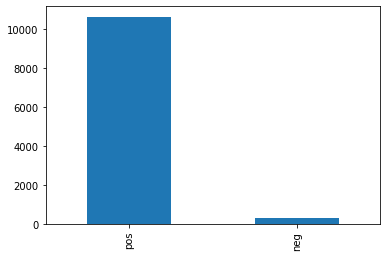

In [10]:
senti['senti'].value_counts().plot.bar()

In [11]:
temp.groupby('asins')['reviews.rating'].agg(['mean','count','std']).sort_values(by = ['mean','count'])

,mean,count,std
asins,,,
B006GWO5WK,2.461538,13,1.853617
B00QL1ZN3G,3.066667,15,1.709915
B00UH4D8G2,3.125000,8,2.031010
B002Y27P6Y,3.500000,10,1.840894
B005PB2T2Q,3.666667,6,1.211060
B00LW9XOJM,3.923077,13,1.441153
B005PB2T0S,4.000000,5,0.707107
B00QFQRELG,4.205479,73,1.384025
B00X4WHP5E,4.285714,7,1.112697


In [12]:
temp[temp.asins == 'B006GWO5WK'].loc[:,'reviews.text']

34647    Excellent charging quality with heavy duty cor...
34648    This charger (9W) rapid charger is as describe...
34649    just what i expected and just what I wanted. t...
34650    Although the description states that this will...
34651                                     Connects snugly!
34652    So I was already not too pleased with Amazon's...
34653    As a charger, it works but is nothing special....
34654    This is exactly like any other usb power charg...
34655    This is not appreciably faster than any other ...
34656    Amazon should include this charger with the Ki...
34657    Love my Kindle Fire but I am really disappoint...
34658    I was surprised to find it did not come with a...
34659    to spite the fact that i have nothing but good...
Name: reviews.text, dtype: object

Above product is a charger and customers are using phrases like - not fast enough, did not contain, nothing special, bad amazon's choice etc. These can be extracted from data with pareto chart to analyze the top complaints.

In [13]:
print("Top 5 positive reviews : ")
temp[temp.asins == 'B006GWO5WK'].loc[:,'reviews.text'][0:5]

Top 5 positive reviews : 


34647    Excellent charging quality with heavy duty cor...
34648    This charger (9W) rapid charger is as describe...
34649    just what i expected and just what I wanted. t...
34650    Although the description states that this will...
34651                                     Connects snugly!
Name: reviews.text, dtype: object

In [14]:
print("Top 5 negative reviews : ")
temp[temp.asins == 'B006GWO5WK'].loc[:,'reviews.text'][-6:-1]

Top 5 negative reviews : 


34654    This is exactly like any other usb power charg...
34655    This is not appreciably faster than any other ...
34656    Amazon should include this charger with the Ki...
34657    Love my Kindle Fire but I am really disappoint...
34658    I was surprised to find it did not come with a...
Name: reviews.text, dtype: object